In [1]:
sigma = 5.67e-8
Q = 342
albedo = 0.3

Te = (((1-0.3)*Q)/sigma)**(1/4)
Te

254.909060186948

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
 ncep = xr.open_dataset('./files/air.mon.ltm.1981-2010.nc', 
                        use_cftime=True)

In [4]:
ncep

<xarray.Dataset>
Dimensions:             (level: 17, lat: 73, lon: 144, time: 12, nbnds: 2)
Coordinates:
  * level               (level) float32 1e+03 925.0 850.0 ... 30.0 20.0 10.0
  * lat                 (lat) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * lon                 (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) object ...
    air                 (time, level, lat, lon) float32 ...
    valid_yr_count      (time, level, lat, lon) float32 ...
Attributes:
    description:                     Data from NCEP initialized reanalysis (4...
    platform:                       Model
    Conventions:                    COARDS
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...
    history:                        Created 2011/07/12 by doMonthLTM\nConvert...
    title:                          monthly ltm air from the NCEP Reanalysis
    dataset_title:                  NCEP-NCAR Reanalysis 1
    References:                     http://www.psl.noaa.gov/data/gridded/data...

In [5]:
# calculate the area-weighted temperature over its domain. This dataset has a regular latitude/ longitude grid, 
# thus the grid cell area decreases towards the pole. For this grid we can use the cosine of the latitude as proxy 
# for the grid cell area.
weights = np.cos(np.deg2rad(ncep.lat))

# Use the xarray function to weight the air temperature array
air_weighted = ncep.air.weighted(weights)

# Take the mean over lat/lon/time to get a mean vertical profile
weighted_mean = air_weighted.mean(("lat","lon", "time"))

In [6]:
weighted_mean

<xarray.DataArray 'air' (level: 17)>
array([ 15.179282  ,  11.207146  ,   7.8384285 ,   0.21994208,
        -6.448425  , -14.889038  , -25.570799  , -39.3702    ,
       -46.79852   , -53.65295   , -60.564327  , -67.006966  ,
       -65.533806  , -61.48741   , -55.854294  , -51.594624  ,
       -43.220547  ], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0

In [7]:
# Import the metpy library
from metpy.plots import SkewT

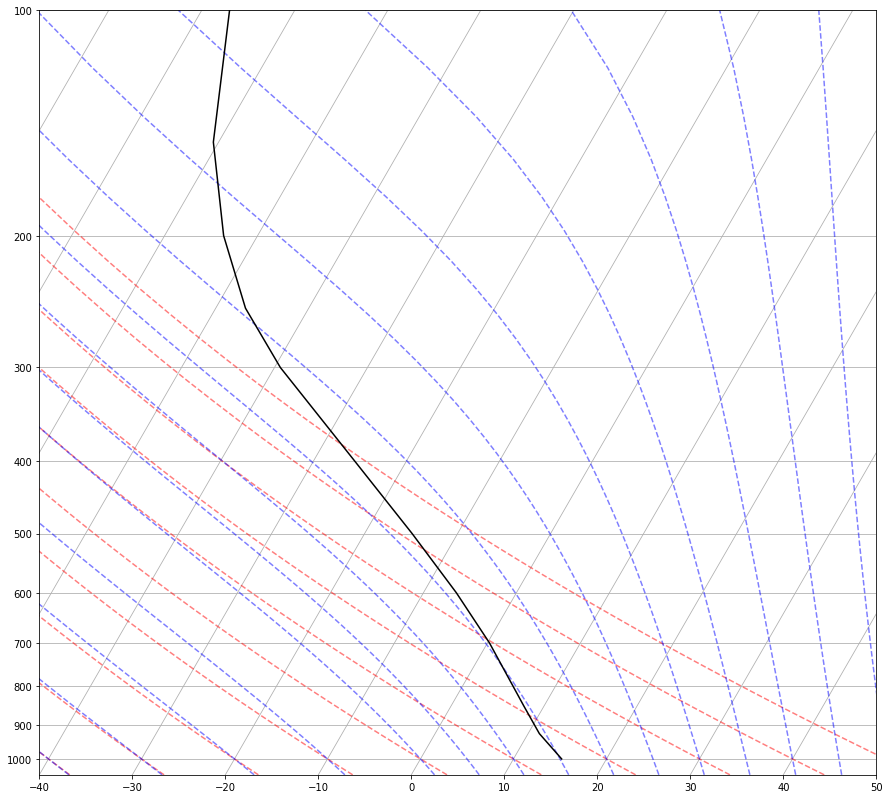

In [8]:
fig = plt.figure(figsize=(15,15))
skew = SkewT(fig, rotation=30)
skew.plot(weighted_mean.level, weighted_mean, color='black', linestyle='-')

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()

In [9]:
Ts = 2**(1/4) * Te
Ts

303.1396680529754

In [10]:
def two_layer_model(Ts, T0, T1, epsilon):
    sigma = 5.68e-8
    return ((1-epsilon)**2)*sigma*Ts**4 + \
        epsilon*(1-epsilon)*sigma*T0**4 + \
        epsilon*sigma*T1**4

In [11]:
two_layer_model(288, 270, 250, 0.6)

268.093815571968

In [12]:
OLR = []
epsilons = []
OLR_obs = 238.5

def find_nearest(array, value):
    idx, val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

for eps in np.arange(0, 1, 0.01):
    OLR.append(OLR_obs - two_layer_model(288.0, 275.0, 230, eps))
    epsilons.append(eps)
    
# Find the closest value
idx = find_nearest(OLR, 0)

# Save the optimized epsilon
epsilon = epsilons[idx]

print('The optimized epsilon is: {:.2f}'.format(epsilons[idx]))


The optimized epsilon is: 0.59


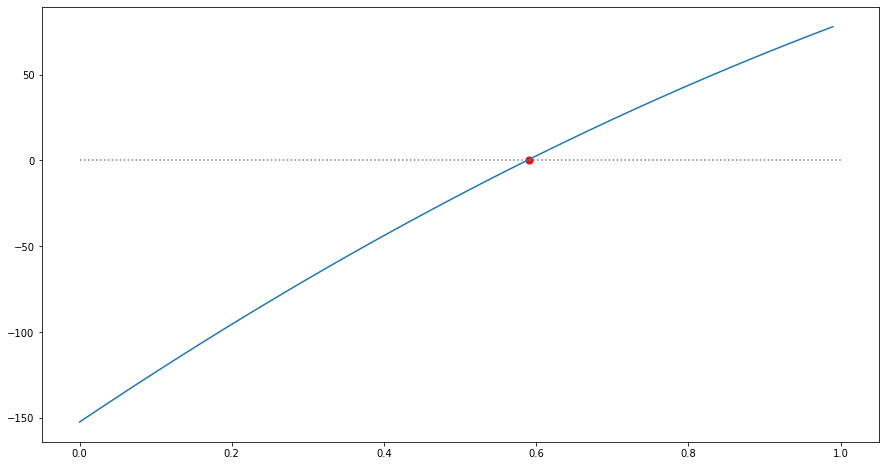

In [13]:
plt.figure(figsize=(15,8))
plt.plot(epsilons, OLR)
plt.scatter(epsilons[idx], OLR[idx], s=50, color='r')
plt.hlines(0,0,1,linestyle='dotted',color='gray')

In [14]:
two_layer_model(288,275,230,0.59)

238.04884468734886

In [15]:
def two_layer_term(Ts, T0, T1, epsilon):
    sigma = 5.68e-8
    return ((1-epsilon)**2)*sigma*Ts**4, \
        epsilon*(1-epsilon)*sigma*T0**4, \
        epsilon*sigma*T1**4

In [16]:
term1, term2, term3 = two_layer_term(288, 288, 288, 0.59)

In [17]:
print('Term 1: {:.2f}'.format(term1))
print('Term 2: {:.2f}'.format(term2))
print('Term 3: {:.2f}'.format(term3))
print('Total: {:.2f}'.format(term1+term2+term3))

Term 1: 65.69
Term 2: 94.53
Term 3: 230.55
Total: 390.77
